# Stanford Stats 191

## Introduction

This is a re-creation of the Stanford Stats 191 course (see https://web.stanford.edu/class/stats191/), using Python eco-system tools, instead of R. This is lecture "Diagnostics for multiple regression"


## Initial Notebook Setup

```watermark ``` documents the current Python and package environment, ```black``` is my preferred Python formatter

In [112]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [113]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [114]:
%matplotlib inline

All imports go here

In [115]:
import pandas as pd
import numpy as np
import seaborn as sn

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
import statsmodels.api as sm

from statsmodels.stats.stattools import jarque_bera

import os

----
## Create and Explore Data

We read in a dataset relating to mountain climbing races in the UK 

In [116]:
data = pd.read_csv('../data/hills.csv', sep='\t')

In [117]:
data.head()

,Race,Distance,Climb,Time
0,Greenmantle,2.5,650,16.083
1,Carnethy,6.0,2500,48.350
2,CraigDunain,6.0,900,33.650
3,BenRha,7.5,800,45.600
4,BenLomond,8.0,3070,62.267


In [118]:
data.sort_values(by='Distance').tail()

,Race,Distance,Climb,Time
16,SevenHills,14.0,2200,98.417
6,BensofJura,16.0,7500,204.617
32,TwoBreweries,18.0,5200,170.250
34,MoffatChase,20.0,5000,159.833
10,LairigGhru,28.0,2100,192.667


## Visualize Data

We use  Seaborn to visually explore the relationships between the variables

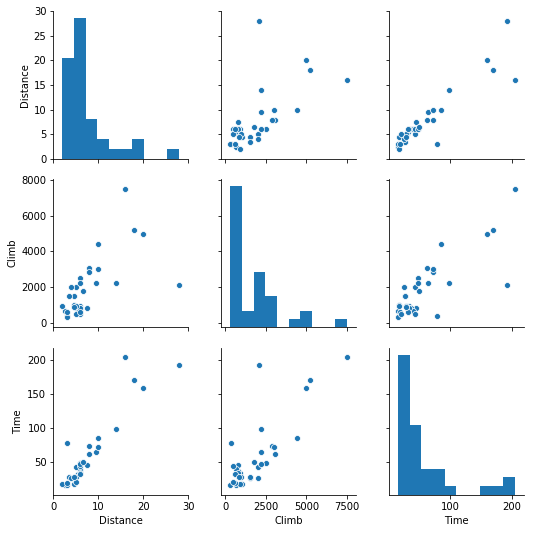

In [119]:
sn.pairplot(data)

Same graph as before, but we also add a regression line to each scatter plot

D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


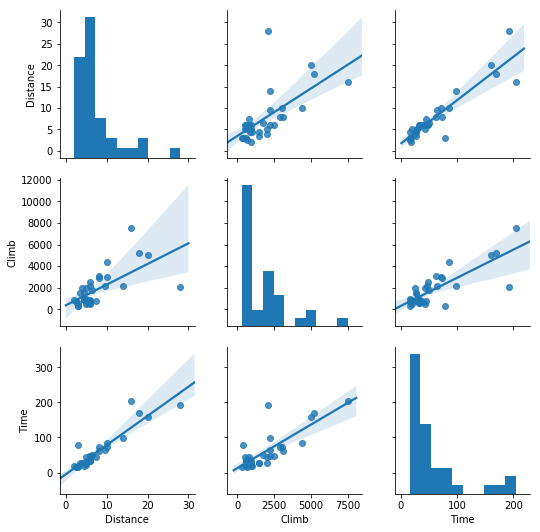

In [120]:
sn.pairplot(data, kind='reg')

We choose to highlight a particular race that looks unusual. We do this by linking the color of the dot (```hue```) to the race name

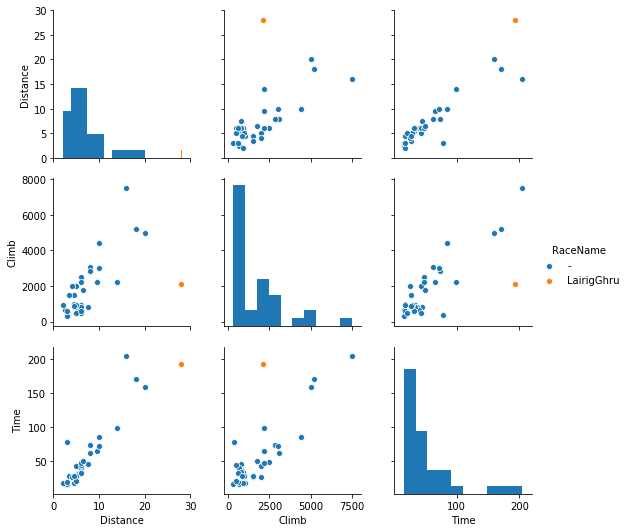

In [121]:
data['RaceName'] = [
    'LairigGhru' if r == 'LairigGhru' else '-'
    for r in data['Race']
]
sn.pairplot(
    data, kind='scatter', diag_kind='hist', hue='RaceName'
)

We can also use ```pandas``` to do our scatter plots

D:\Anaconda3\envs\ac5-py37\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


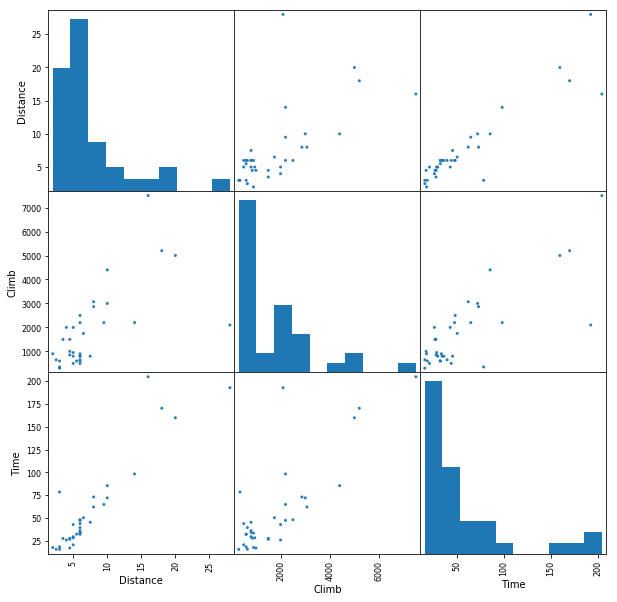

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
__ = pd.plotting.scatter_matrix(
    data, ax=ax, alpha=0.95, grid=False
)

-----
## Perform OLS

We build a model where time to complete the race depends linearly upon the distance, and height to climb (and of course, a Gaussian error term)

In [123]:
res = ols('Time ~ Distance + Climb', data=data).fit()

In [124]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Time   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     181.7
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           3.40e-18
Time:                        19:11:56   Log-Likelihood:                -142.11
No. Observations:                  35   AIC:                             290.2
Df Residuals:                      32   BIC:                             294.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.9920      4.303     -2.090      0.045     -17.756      -0.228
Distance       6.2180      0.601     10.343      0.000       4.993       7.442
Climb          0.0110      0.002      5.387      0.000       0.007       0.015
==============================================================================
Omnibus:                       47.910   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.976
Skew:                           3.026   Prob(JB):                     1.56e-51
Kurtosis:                      14.127   Cond. No.                     4.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

-------
## Checking the Model

### Display Raw Residuals

One way to confirm our model is relecting reality, is to plot the residuals (actual time - predicted time)

We see one or two unusual values, but most residuals appear random

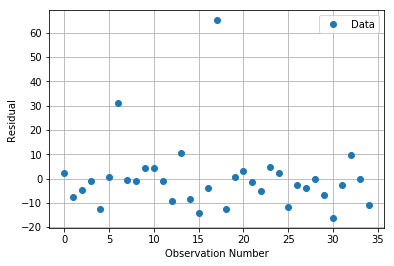

In [125]:
_ = plt.plot(res.resid, 'o', label='Data')
_ = plt.legend(loc='best')
_ = plt.grid()
_ = plt.xlabel('Observation Number')
_ = plt.ylabel('Residual')
_ = plt.legend()

We can also plot our two explanatory variables against the predicted and actual values of time 

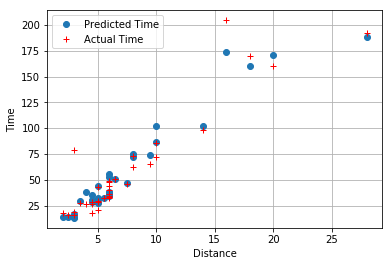

In [126]:
_ = plt.plot(
    data['Distance'],
    res.predict(),
    'o',
    label='Predicted Time',
)
_ = plt.plot(
    data['Distance'],
    data['Time'],
    'r+',
    label='Actual Time',
)
_ = plt.legend(loc='best')
_ = plt.grid()
_ = plt.xlabel('Distance')
_ = plt.ylabel('Time')
_ = plt.legend()

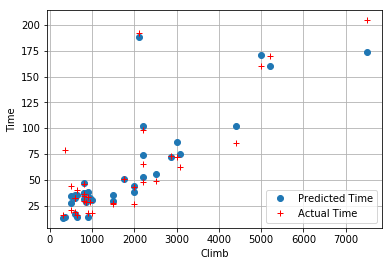

In [127]:
plt.plot(
    data['Climb'],
    res.predict(),
    'o',
    label='Predicted Time',
)
plt.plot(
    data['Climb'], data['Time'], 'r+', label='Actual Time'
)
_ = plt.legend(loc='best')
_ = plt.grid()
_ = plt.xlabel('Climb')
_ = plt.ylabel('Time')
_ = plt.legend()

We can graph a more detailed view of the residuals, and of residuals plotted against prediction

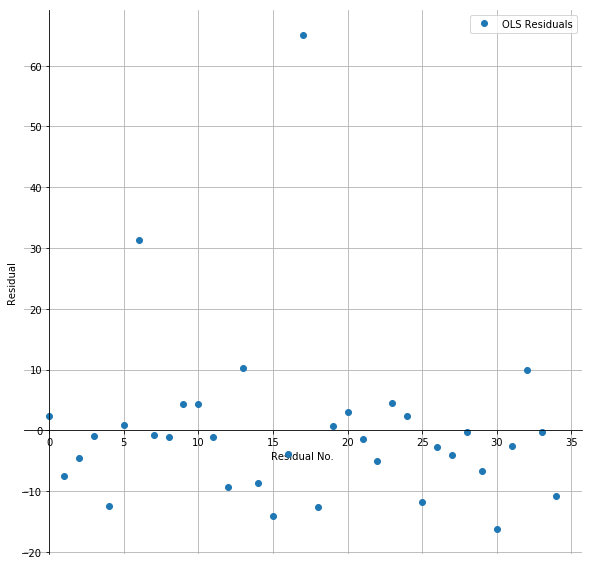

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(
    range(len(res.resid)),
    res.resid,
    'o',
    label='OLS Residuals',
)


ax.grid()
ax.set_xlabel('Residual No.')
ax.set_ylabel('Residual')


ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.legend(loc='best')

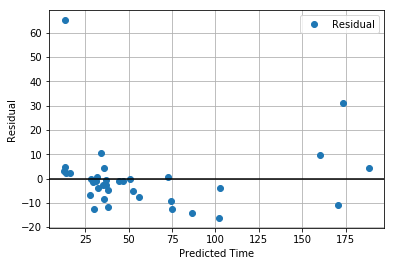

In [129]:
plt.plot(res.predict(), res.resid, 'o', label='Residual')
_ = plt.legend(loc='best')
_ = plt.grid()
_ = plt.xlabel('Predicted Time')
_ = plt.ylabel('Residual')
_ = plt.axhline(0, c='k')
_ = plt.legend()

----
### Display Normality Test Plots

One way to check for the normality of the residuals is to plot the actual quantiles against theoretical quantiles (assuming a normal distribution).  We see that because of two outliers, we do not get the expected straight line 

There are two ways of getting QQ Plots, via ```statsmodels``` (qqplot() ), and via ```scipy.stats``` (probplot() )

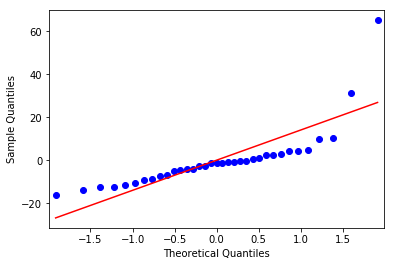

In [130]:
fig = sm.qqplot(res.resid, line='s')

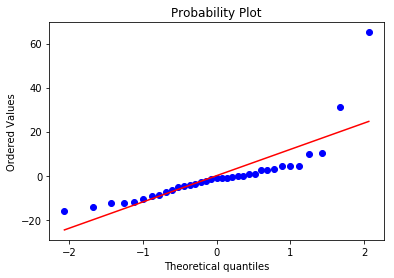

In [131]:
__ = stats.probplot(res.resid, dist='norm', plot=plt)

A Normal distribution should be a straight line, as below

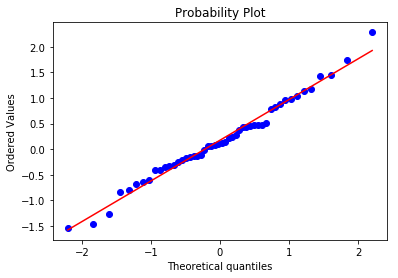

In [132]:
_ = stats.probplot(
    np.random.normal(0, 1, 50), dist='norm', plot=plt
)

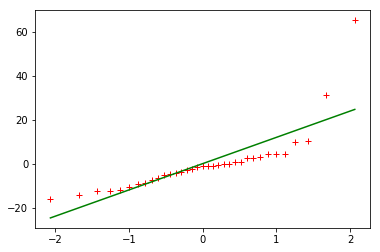

In [133]:
(osm, osr), (slope, intercept, r) = stats.probplot(
    res.resid, dist='norm', plot=None
)
plt.plot(osm, osr, 'r+')
plt.plot(osm, osm * slope + intercept, 'g-')

----
### Plot Studentized Residuals

Plot Studentized Residuals against Residuals.  

Externally Studentized means taking all other residuals (ie excluding the residual under consideration) to get a 'standard deviation', to scale the residual to get a variable that is distributed as per t distribution.

Internally Studentized means taking all  residuals (ie including the residual under consideration) to get a 'standard deviation', to scale the residual to get a variable that is distributed approximately as per t distribution.

The RegressionResults object has a method ```outlier_test```, that returns the two types of "Studentized" residuals

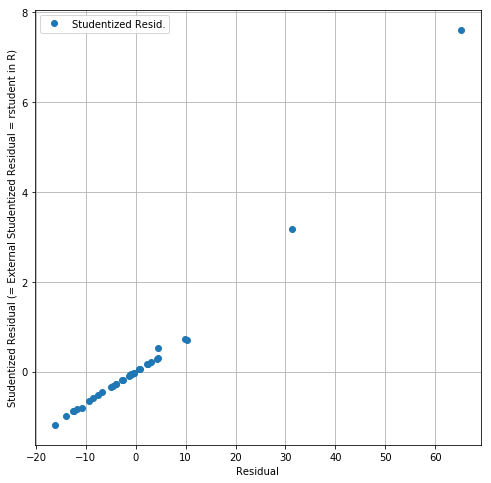

In [134]:
res_df = res.outlier_test()
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(
    res.resid,
    res_df['student_resid'],
    'o',
    label='Studentized Resid.',
)
ax.set_xlabel('Residual')
ax.set_ylabel(
    'Studentized Residual (= External Studentized Residual = rstudent in R)'
)
ax.grid()
ax.legend(loc='best')

As we see above, we have a smallnumber of residuals that require closer attention

The ```outlier_test()``` method returns a pandas DataFrame as below. The column ```student_resid``` is the Externally Studentized Residuals as discussed above.  The columns ```unadj_p``` and ```bonf(p)``` columns are discussed below

In [135]:
res_df.head()

,student_resid,unadj_p,bonf(p)
0,0.162024,0.872339,1.0
1,-0.524115,0.603926,1.0
2,-0.315720,0.754331,1.0
3,-0.060574,0.952087,1.0
4,-0.866026,0.393129,1.0


We can also get the standardized residuals (both types) from the OLSInfluence object, using a method ```get_influence()``` in the RegressionResults object.

In [136]:
influence = res.get_influence()

In [137]:
type(influence)

statsmodels.stats.outliers_influence.OLSInfluence

In [138]:
standardized_residuals_int = (
    influence.resid_studentized_internal
)
standardized_residuals_ext = (
    influence.resid_studentized_external
)

### Outlier_test results (Bonferroni Adjustment)

The approach we could take is to look at the residuals for each race (actual time - predicted time), and reject those observations where the residual is unexpectedly large.  That is, larger than a pre-chosen threshold (e.g. a residual of this size would only happen at a frequency of 5%, or 1%, or at whatever our chosen cutoff frequency was).  The problem with this approach is that the error term in our model is random, and if we have a very large number of valid data points, then we expect 5% of them to be exceed our threshold, if we have set 5% as our threshold. 

Carlo Emilio Bonferroni (an Italian mathematician) developed a correction that reduces the number of valid data points being rejected.

The DataFrame returned by ```outlier_test``` , holds (for each observation) the probability that we would see a residual of this size by random chance (assuming all residuals are T-distributed).  The ```bonfp()``` column I understand to be probability that the observation is valid (after the Bonferroni adjustment).

In [139]:
res_df.head()

,student_resid,unadj_p,bonf(p)
0,0.162024,0.872339,1.0
1,-0.524115,0.603926,1.0
2,-0.315720,0.754331,1.0
3,-0.060574,0.952087,1.0
4,-0.866026,0.393129,1.0


We can use develop a boolean mask that extracts those observations that are very surprising (i.e. almost certainly not valid)

In [140]:
outlier_m = [r < 0.05 for r in res_df['bonf(p)']]
print(res_df[outlier_m])
print(data[outlier_m])

    student_resid       unadj_p       bonf(p)
17       7.610845  1.397273e-08  4.890457e-07
         Race  Distance  Climb   Time RaceName
17  KnockHill       3.0    350  78.65        -


We can plot the unadjusted and adjusted probabilities, and a 5% cutoff line.  We see the one point below the cutoff.

Text(0, 0.5, 'Probability')

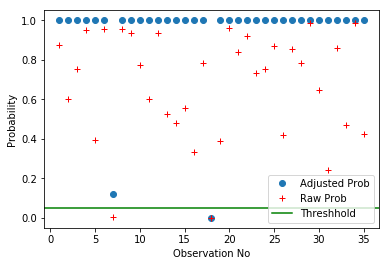

In [141]:
idf = range(1, len(data) + 1)
plt.plot(idf, res_df['bonf(p)'], 'o', label='Adjusted Prob')
plt.plot(idf, res_df['unadj_p'], 'r+', label='Raw Prob')
plt.axhline(0.05, c='g', label='Threshhold')
plt.legend(loc='best')
plt.xlabel('Observation No')
plt.ylabel('Probability')

It turns out that the datset has a known error  (http://www.statsci.org/data/general/hills.html)

> The data contains a known error - Atkinson (1986) reports that the record for Knock Hill (observation 17) should actually be 18 minutes rather than 78 minutes.

## Extended Analysis of Residuals

We see that ```outlier_test()``` returns the same array as the ```influence.resid_studentized_external```

we will compare the externally and internally standardized residuals for each point; again we see a few suspicious points

In [142]:
res_df.head()

,student_resid,unadj_p,bonf(p)
0,0.162024,0.872339,1.0
1,-0.524115,0.603926,1.0
2,-0.315720,0.754331,1.0
3,-0.060574,0.952087,1.0
4,-0.866026,0.393129,1.0


In [143]:
print(
    'outlier_test student_resid ',
    standardized_residuals_ext[0:5],
)

standardized_residuals_int = (
    influence.resid_studentized_internal
)
standardized_residuals_ext = (
    influence.resid_studentized_external
)
print(
    'External Stud Resid        ',
    standardized_residuals_ext[0:5],
)

print(
    'Internal Stud Resid        ',
    standardized_residuals_int[0:5],
)

outlier_test student_resid  [ 0.16202389 -0.52411478 -0.31572031 -0.06057395 -0.86602567]
External Stud Resid         [ 0.16202389 -0.52411478 -0.31572031 -0.06057395 -0.86602567]
Internal Stud Resid         [ 0.16454678 -0.53015742 -0.32025768 -0.06153956 -0.86942853]


Display the plots of Externally Studentized Residuals versus the Residuals, and Internally Studentized Residuals.  Valid points should like close to a straight line.  Again we see a few points that are 'suspicious'

Text(0.5, 0.98, 'Standard Residuals\n(as per\nhttps://web.stanford.edu/class/stats191/notebooks/Diagnostics_for_multiple_regression.html')

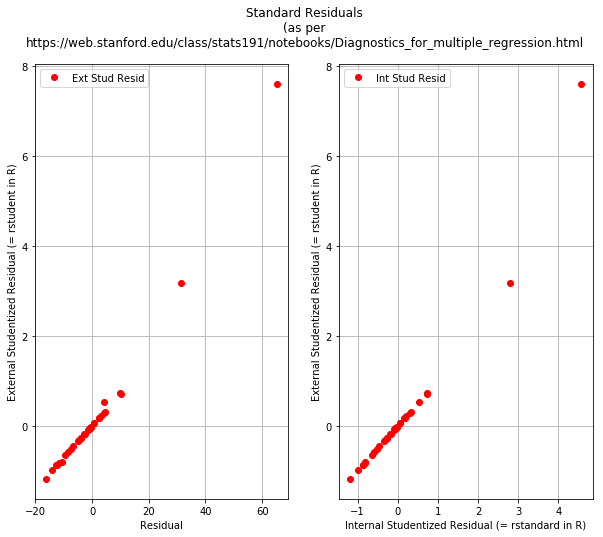

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

ax[0].plot(
    res.resid,
    standardized_residuals_ext,
    'ro',
    label='Ext Stud Resid',
)
ax[0].set_xlabel('Residual')
ax[0].set_ylabel(
    'External Studentized Residual (= rstudent in R)'
)
ax[0].grid()
ax[0].legend(loc='best')

ax[1].plot(
    standardized_residuals_int,
    standardized_residuals_ext,
    'ro',
    label='Int Stud Resid',
)
ax[1].set_ylabel(
    'External Studentized Residual (= rstudent in R)'
)
ax[1].set_xlabel(
    'Internal Studentized Residual (= rstandard in R)'
)
ax[1].grid()
ax[1].legend(loc='best')

fig.suptitle(
    'Standard Residuals\n(as per\n'
    + 'https://web.stanford.edu/class/stats191/notebooks/Diagnostics_for_multiple_regression.html'
)

---
### Constant Variance Test

We look at what is some sense the 'variance' of each externally standardize residual, and again can identify a few points that seem different from the others.  Otherwise the variance appears to be constant

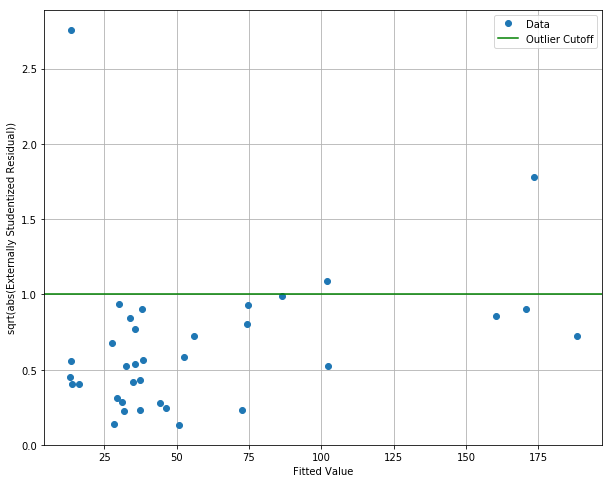

In [145]:
zz = np.sqrt(np.abs(standardized_residuals_ext))


fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(res.predict(), zz, 'o', label='Data')
ax.set_xlabel('Fitted Value')
ax.set_ylabel('sqrt(abs(Externally Studentized Residual))')
ax.grid()
ax.axhline(1, c='g', label='Outlier Cutoff')
ax.legend(loc='best')

We can plot the residuals against the predicted values.  Again variance appear constant across the range of predicted values

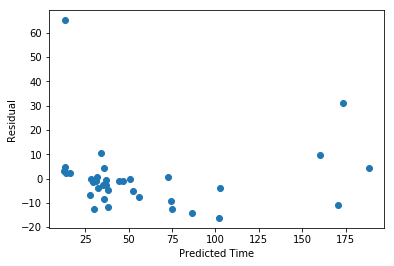

In [146]:
plt.plot(res.predict(), res.resid, 'o')
_ = plt.xlabel('Predicted Time')
_ = plt.ylabel('Residual')

-----

## Measure of Influence

### DFFITS

DFFITS (standing for Difference in Fits) is a measure of how influential an observation is, gauged by seeing how the prediction for an observation changes if the observation is excluded from the regression.

The OLSInfluence object can be used to get this value for each observation

$$DFFITS_i = \frac{\widehat{Y}_i - \widehat{Y}_{i(i)}}{\widehat{\sigma}_{(i)} \sqrt{H_{ii}}}$$

In [147]:
# df[0] is an array of the DFFITS value for each observation
# df[1] is the suggested threshhold for suspicious DFFITS values (= 2 * sqrt(k / n),
# where k is the size  of our model [=3, constant, distance, climb])
# where n is the dataset size

df = influence.dffits
df_val = df[0]
df_thresh = df[1]
ldf = len(df_val)

In [148]:
print(f'DFFITS threshhold value = {df_thresh: 15.5f}')

DFFITS threshhold value =         0.58554


Plot our DFFITS, and the threshhold 

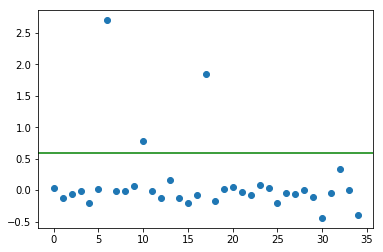

In [149]:
idf = range(ldf)

plt.plot(idf, df_val, 'o')
plt.axhline(df_thresh, c='g')

Show the races for which the DFFITS indicates to be investigated 

In [150]:
outlier = [r > df_thresh for r in df_val]
data[outlier]

,Race,Distance,Climb,Time,RaceName
6,BensofJura,16.0,7500,204.617,-
10,LairigGhru,28.0,2100,192.667,LairigGhru
17,KnockHill,3.0,350,78.650,-


Checking the DFFITS threshhold value returned by the  OLSInfluence object

In [151]:
n_feat = 2
thresh = 2 * np.sqrt((n_feat + 1) / len(data['Time']))
print('Outlier Threshhold ', thresh)

Outlier Threshhold  0.5855400437691199


----
### Cooks Distance

Cooks distance is a measure of how much the whole regression changes, when we delete an observation.  We can get this from the OLSInfluence object.  Two arrays are returned, the first matches the R convention

$$D_i = \frac{\sum_{j=1}^n(\widehat{Y}_j - \widehat{Y}_{j(i)})^2}{(p+1) \, \widehat{\sigma}^2}$$

In [152]:
cooks = influence.cooks_distance

Plot the Cooks Distance for each observation

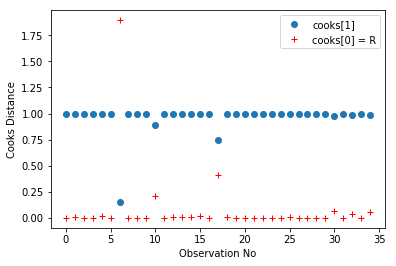

In [153]:
plt.plot(idf, cooks[1], 'o', label='cooks[1]')
plt.plot(
    idf, cooks[0], 'r+', label='cooks[0] = R'
)  # R definition
plt.xlabel('Observation No')
plt.ylabel('Cooks Distance')
plt.legend(loc='best')

Again we get  mask in the races with Cooks Distance over a threshhold, and we get our usual suspects

In [154]:
outlier = [r > 0.1 for r in cooks[0]]
data[outlier]

,Race,Distance,Climb,Time,RaceName
6,BensofJura,16.0,7500,204.617,-
10,LairigGhru,28.0,2100,192.667,LairigGhru
17,KnockHill,3.0,350,78.650,-


-----
### DFBETA

DFBETA measures the difference in the estimated coefficients when a single observation is removed from the OLS fit.   We can get this from the OLSInfluence object. 

Because we are estimating three parameters (constant, climb, distance), we get three arrays back

$$DFBETAS_{j(i)} = \frac{\widehat{\beta}_j - \widehat{\beta}_{j(i)}}{\sqrt{\widehat{\sigma}^2_{(i)} (X^TX)^{-1}_{jj}}}.$$

In [155]:
dfbetas = influence.dfbetas
type(dfbetas)

numpy.ndarray

Plot the influence observations have over the coefficient of ```Climb``` 

In [156]:
dfb0 = [r[0] for r in dfbetas]
dfb1 = [r[1] for r in dfbetas]
dfb2 = [r[2] for r in dfbetas]

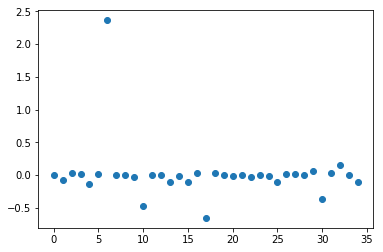

In [157]:
plt.plot(idf, dfb2, 'o')
# Climb

Plot the influence each observation has on the ```Distance``` coefficient

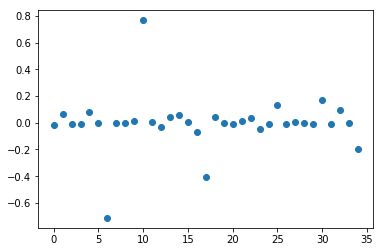

In [158]:
plt.plot(idf, dfb1, 'o')
# Distance

Combine the two plots, and draw threshhold at +-2* sqrt(n)

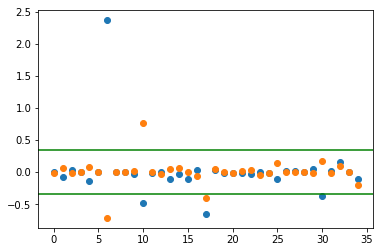

In [159]:
plt.plot(idf, dfb2, 'o')  # Climb
plt.plot(idf, dfb1, 'o')  # Distance
plt.axhline(2 / np.sqrt(len(data['Time'])), c='g')
plt.axhline(-2 / np.sqrt(len(data['Time'])), c='g')

---
## Investigation of outliers

Given that we have a set of unusual races that a number of metrics have fingered, we can use seaborn the show these in the scatter plots.  We explicitly name each suspect race in a new DataFrame column, as assign a placeholder name to all the rest.

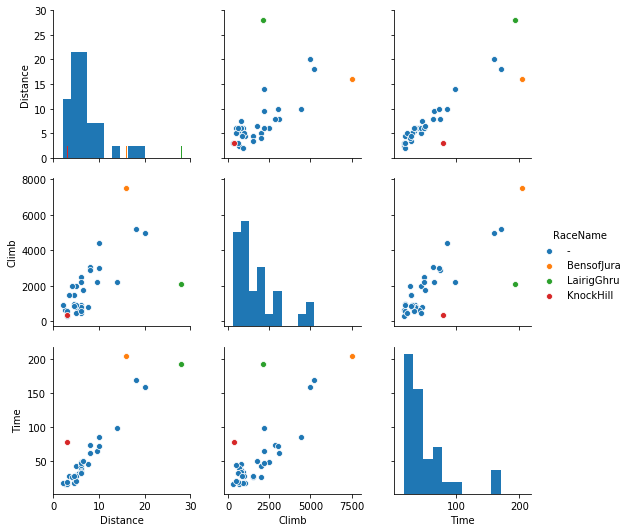

In [160]:
data['RaceName'] = [
    r
    if r in ['BensofJura', 'LairigGhru', 'KnockHill']
    else '-'
    for r in data['Race']
]
sn.pairplot(
    data, kind='scatter', diag_kind='hist', hue='RaceName'
)

One observation we can make is that two of our outliers are indeed outliers in input space, being the longest and highest race.  Having outliers like this might make us question our linear model.  We might ask if runners operate in two biological regimes, sprints and marathons? Should a model that fits short distances be expected to work at long distances?

Outliers like KnockHill we are more likely attribute to human error (as indeed was the case here, reportedly)

### Leverage

We can get a view as to how far an observation is from the norm in input space by using the ```leverage``` concept, defined as below.   We can get this from the OLSInfluence object. 


$$\text{leverage}_i = H_{ii} = (X(X^TX)^{-1}X^T)_{ii}$$

In [161]:
hat = influence.hat_matrix_diag

Plot the leverage values

Text(0, 0.5, 'Leverage')

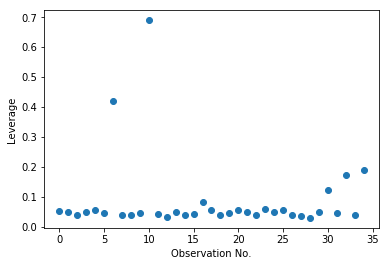

In [162]:
plt.plot(idf, hat, 'o')
plt.xlabel('Observation No.')
plt.ylabel('Leverage')

Print out the outlier races.  We get our races at extremes of distance and height

In [163]:
outlier = [r > 0.3 for r in hat]
data[outlier]

,Race,Distance,Climb,Time,RaceName
6,BensofJura,16.0,7500,204.617,BensofJura
10,LairigGhru,28.0,2100,192.667,LairigGhru


We can display those observation with large residuals, and large leverage

Text(0, 0.5, 'Internally Standardised Residuals')

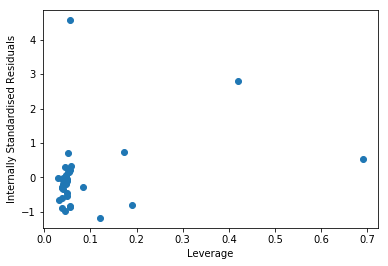

In [164]:
plt.plot(hat, standardized_residuals_int, 'o')
plt.xlabel('Leverage')
plt.ylabel('Internally Standardised Residuals')

A slightly better version of the graph above, done with the OO interface to Matplotlib

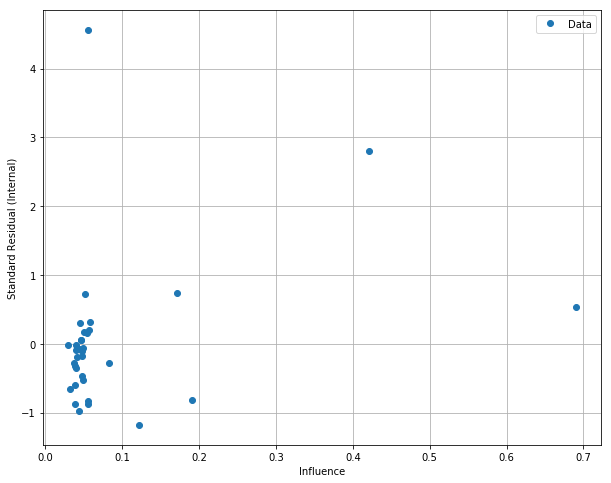

In [165]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(hat, standardized_residuals_int, 'o', label='Data')
ax.set_xlabel('Influence')
ax.set_ylabel('Standard Residual (Internal)')
ax.grid()
ax.legend(loc='best')

```statsmodels``` has a purpose-build graphic for visualizing observation influence.  Once again, we get our usual suspects.

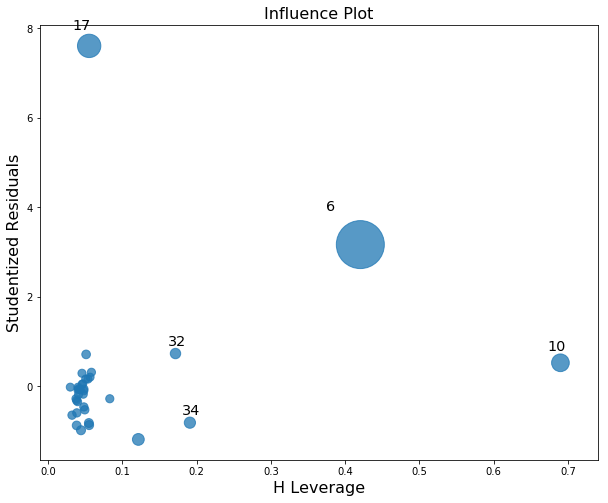

In [166]:
fig, ax = plt.subplots(figsize=(10, 8))

_ = sm.graphics.influence_plot(res, ax=ax)

In [167]:
data.iloc[[17, 6, 10]]

,Race,Distance,Climb,Time,RaceName
17,KnockHill,3.0,350,78.650,KnockHill
6,BensofJura,16.0,7500,204.617,BensofJura
10,LairigGhru,28.0,2100,192.667,LairigGhru


```statsmodels``` has another closely related graphic to plot leverage statistics vs. normalized residuals squared

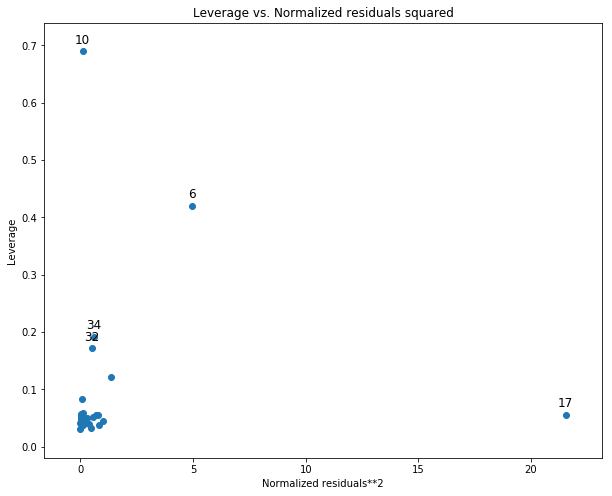

In [168]:
fig, ax = plt.subplots(figsize=(10, 8))

_ = sm.graphics.plot_leverage_resid2(res, ax=ax)

-----
## Excluding Large Residuals

The example below shows the impact of Bonferroni correction.  We plot standardised residuals against fitted value, and set thresholds based upon the T test (at the 95% level)

-2.0395134463964077 2.0395134463964077


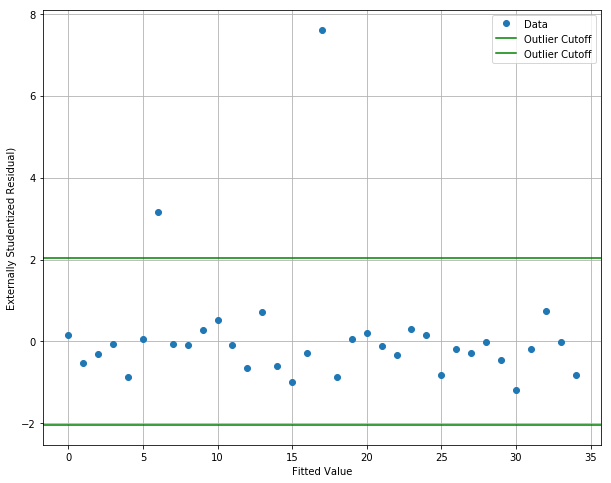

In [169]:
fig, ax = plt.subplots(figsize=(10, 8))

n_features = 2
thresh1, thresh2 = stats.t.interval(
    0.95, len(data['Time']) - n_features - 2
)

ax.plot(idf, standardized_residuals_ext, 'o', label='Data')
ax.set_xlabel('Fitted Value')
ax.set_ylabel('Externally Studentized Residual)')
ax.grid()
ax.axhline(thresh1, c='g', label='Outlier Cutoff')
ax.axhline(thresh2, c='g', label='Outlier Cutoff')
ax.legend(loc='best')
print(thresh1, thresh2)

Because we are looking at many residuals, even under the Null Hypothesis (all observations valid), some will be rejected.  An example below, where all points are genuinely from Normal(0,1), still has some rejected.

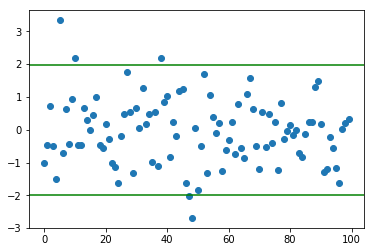

In [170]:
sample = np.random.normal(0, 1, 100)

n_features = 1
thresh1, thresh2 = stats.t.interval(
    0.95, len(sample) - n_features - 2
)
plt.plot(range(100), sample, 'o')
plt.axhline(thresh1, c='g', label='Outlier Cutoff')
plt.axhline(thresh2, c='g', label='Outlier Cutoff')

In [171]:
print(thresh1, thresh2)

-1.984723185927883 1.984723185927883


### Apply Bonferroni Correction (widen acceptance region)

We widen the acceptance region by the Bonferroni correction

-3.501165862689355 3.501165862689384


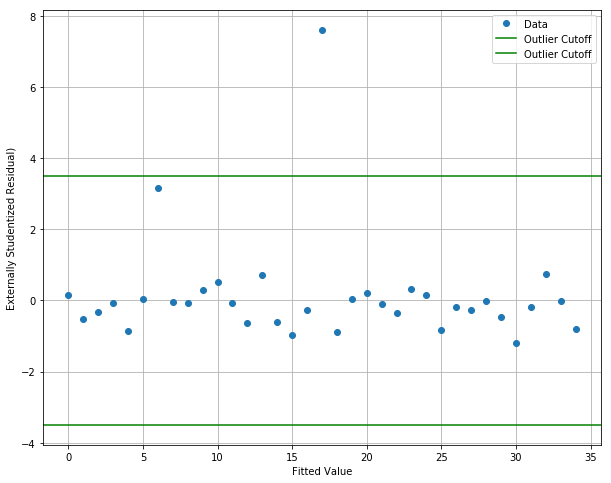

In [172]:
fig, ax = plt.subplots(figsize=(10, 8))

n_points = len(data['Time'])
n_features = 2
alpha = 0.05
thresh1, thresh2 = stats.t.interval(
    1 - alpha / n_points, len(data['Time']) - n_features - 2
)

ax.plot(idf, standardized_residuals_ext, 'o', label='Data')
ax.set_xlabel('Fitted Value')
ax.set_ylabel('Externally Studentized Residual)')
ax.grid()
ax.axhline(thresh1, c='g', label='Outlier Cutoff')
ax.axhline(thresh2, c='g', label='Outlier Cutoff')
ax.legend(loc='best')
print(thresh1, thresh2)

We see that under our new threshholds, onlyone observation is excluded, and it is the one point that we know (from other sources) is not valid

In [173]:
outlier = [
    np.abs(r) > thresh2 for r in standardized_residuals_ext
]
data[outlier]

,Race,Distance,Climb,Time,RaceName
17,KnockHill,3.0,350,78.65,KnockHill


The data contains a known error - Atkinson (1986) reports that the record for Knock Hill (observation 17) should actually be 18 minutes rather than 78 minutes.

-----
## Additional Plots

There are two additional plots that can be used to assess the linear model.  STATS191 calls them "added-variable and component plus residual plots"; ```statsmodel``` calls them "partial regression  plot for a set of regressors" and "component and component-plus-residual (CCPR) plots" respectively

Both graphics seem to support our linear model

### CCPR

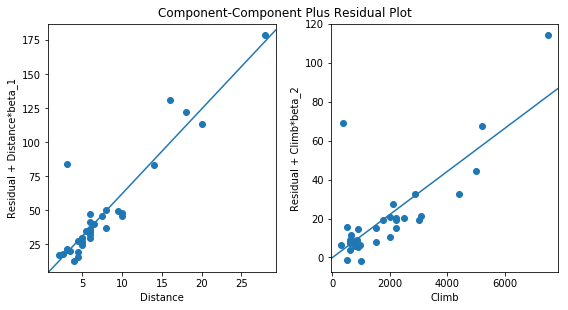

In [174]:
fig = plt.figure(figsize=(8, 8))
_ = sm.graphics.plot_ccpr_grid(res, fig=fig)
plt.show()

### Partial Regression Plot

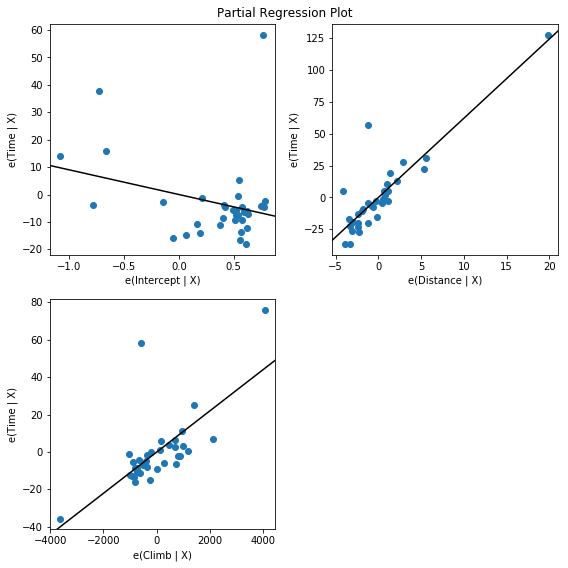

In [175]:
fig = plt.figure(figsize=(8, 8))
_ = sm.graphics.plot_partregress_grid(res, fig=fig)


---------
## Reproducibility

In [176]:
%watermark -h -iv
%watermark

scipy       1.1.0
matplotlib  3.0.2
numpy       1.15.4
seaborn     0.9.0
statsmodels 0.9.0
pandas      1.0.0
host name: DESKTOP-SODFUN6
2020-03-23T19:12:05+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
